In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import cv2
import matplotlib.pyplot as plt
import random

from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers
import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [ ]:
data_path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'


In [ ]:
classes = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])

print("Dataset Classes:")
for cls in classes:
    print(cls)

Dataset Classes:
lung_aca
lung_n
lung_scc


In [ ]:
def create_dataframe(data_path):
    filepaths = []  // لإنشاء قائمة لتخزين المسارات للصور
    labels = []  إنشاء قائمة لتخزين  (classes) الخاصة بكل صورة.

    for fold in os.listdir(data_path): // بيعدي علي كل فولدر في مسار الداتا
        f_path = os.path.join(data_path, fold) // بيتاكد ان كان العنصر فولدر مش فايل
        if os.path.isdir(f_path):
            imgs = os.listdir(f_path)
            for img in imgs:
                img_path = os.path.join(f_path, img)
                filepaths.append(img_path)
                labels.append(fold)

    fseries = pd.Series(filepaths, name='Filepaths') // بيحول قايمه ال paths لعمود في الداتا فريم
    lseries = pd.Series(labels, name='Labels')
    return pd.concat([fseries, lseries], axis=1) // بيدمج كل الاعمده في داتا فرمي واحده

# Create DataFrame for the dataset
df = create_dataframe(data_path)

In [ ]:
# Step 1: Split into 70% training and 30% dummy, stratifying by labels
train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=42, stratify=df['Labels'])

# Step 2: Split dummy_df into 20% testing and 10% validation, stratifying by labels
test_df, valid_df = train_test_split(dummy_df, train_size=2/3, shuffle=True, random_state=42, stratify=dummy_df['Labels'])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255) //كل قيمة بكسل في الصورة (اللي بالأصل بين 0 و255) يتم تطبيعها لتكون بين 0 و1.

# Validation and test data generators remain the same
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 10500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


In [ ]:
# Load the VGG16 model, excluding the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base to retain the pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for our specific classification task
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train the model and store training details in history
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    batch_size=32
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 141s 378ms/step - accuracy: 0.8628 - loss: 0.3182 - val_accuracy: 0.9613 - val_loss: 0.1039
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 61s 183ms/step - accuracy: 0.9588 - loss: 0.1050 - val_accuracy: 0.9713 - val_loss: 0.0737
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 61s 182ms/step - accuracy: 0.9693 - loss: 0.0798 - val_accuracy: 0.9793 - val_loss: 0.0608
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 61s 181ms/step - accuracy: 0.9802 - loss: 0.0568 - val_accuracy: 0.9687 - val_loss: 0.0869
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 61s 183ms/step - accuracy: 0.9837 - loss: 0.0469 - val_accuracy: 0.9807 - val_loss: 0.0515
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 61s 183ms/step - accuracy: 0.9866 - loss: 0.0411 - val_accuracy: 0.9853 - val_loss: 0.0432
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 61s 182ms/step - accuracy: 0.9894 - loss: 0.0327 - val_accuracy: 0.9827 - val_loss: 0.0481
Epoch 8/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 61s 181ms/step - accuracy: 0.9896 - loss: 0.0272 - va

In [ ]:
# Evaluate the model on the training data
train_scores = model.evaluate(train_generator, verbose=0)
print(f"Training Loss: {train_scores[0]:.4f}")
print(f"Training Accuracy: {train_scores[1]:.4f}")

# Evaluate the model on the test data
test_scores = model.evaluate(test_generator, verbose=0)
print(f"Test Loss: {test_scores[0]:.4f}")
print(f"Test Accuracy: {test_scores[1]:.4f}")

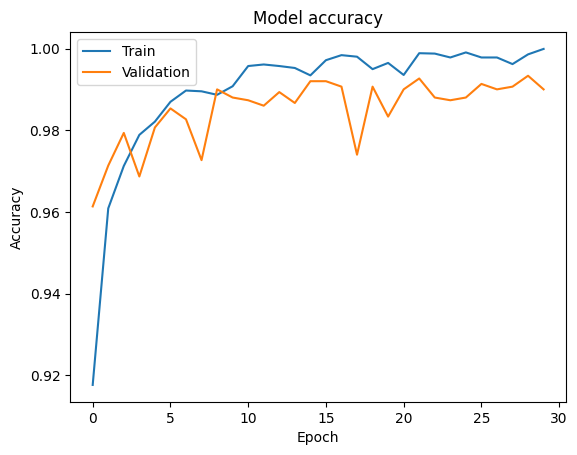

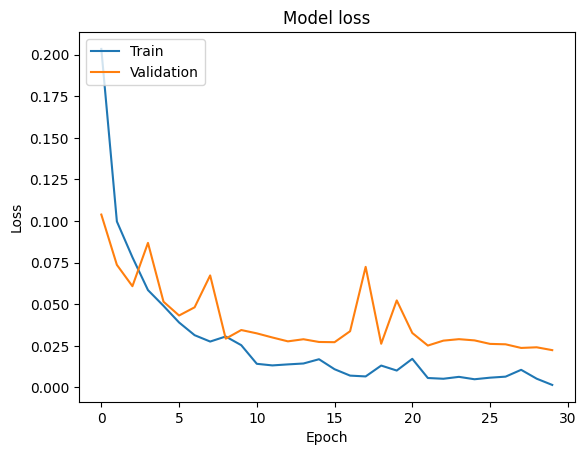

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step


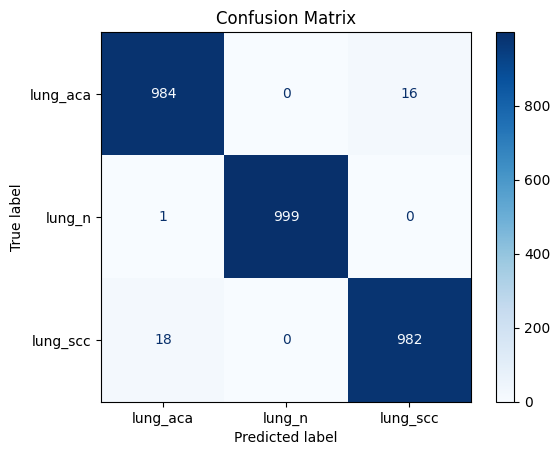

In [ ]:
predictions = model.predict(test_generator)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

cm = confusion_matrix(true_classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step
              precision    recall  f1-score   support

    lung_aca       0.98      0.98      0.98      1000
      lung_n       1.00      1.00      1.00      1000
    lung_scc       0.98      0.98      0.98      1000

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [ ]:
def predict(model, img, class_names):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

class_names = list(test_generator.class_indices.keys())

images_batch, labels_batch = next(test_generator)
for i in range(min(len(images_batch), 9)):
    predicted_class, confidence = predict(model, images_batch[i], class_names)
    actual_class = class_names[np.argmax(labels_batch[i])]

    print(f"Actual: {actual_class}, Predicted: {predicted_class}, Confidence: {confidence}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Actual: lung_scc, Predicted: lung_scc, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Actual: lung_aca, Predicted: lung_aca, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Actual: lung_n, Predicted: lung_n, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Actual: lung_n, Predicted: lung_n, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual: lung_n, Predicted: lung_n, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Actual: lung_scc, Predicted: lung_scc, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual: lung_aca, Predicted: lung_aca, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Actual: lung_scc, Predicted: lung_scc, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Actual: lung_scc, Predicted: lung_scc, Confidence: 100.0%


In [ ]:
model.save("Model_vgg16.h5")